# 1. Factor Engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from tqdm import tqdm
import pandas as pd
import polars as pl
import glob
import os


## 1.1 Feature Generation
### 1.1.1 Book Features
We first processes raw order book data and extracts meaningful features for modeling. The following table is the summary of the feature we generated from the original datasets.

| Feature Name            | Formula                                                                                                                                         | Reason for Inclusion                                                                                         |
| ----------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| **`wap1/2`**              | $ \frac{\text{ask\_price}_{1/2} \cdot \text{bid\_size}_{1/2} + \text{bid\_price}_{1/2} \cdot \text{ask\_size}_{1/2}}{\text{ask\_size}_{1/2} + \text{bid\_size}_{1/2}}$ | Weighted Average Price at depth 1/2. This smooths out the impact of individual order prices using size as weight. It approximates the "fair" market price better than simple mid-price. Including wap2 captures more of the limit order book’s shape. 
| **`bid_size_diff`**     | $\text{bid\_size}_1 - \text{bid\_size}_2$                                                                                      | Captures the change in demand depth between level 1 and level 2. Large differences may imply lower resilience in the order book.                  |
| **`ask_size_diff`**     | $\text{ask\_size}_1-\text{ask\_size}_2$                                                                                | Measures ask-side change. Can signal a lack of liquidity on the sell side or increased selling pressure.                              |
| **`price_spread`**      | $ \frac{\text{ask\_price}_1}{\text{bid\_price}_1} - 1$                                                                                |A measure of transaction cost and short-term illiquidity.       |
| **`order_imbalance_1/2`** | $\frac{\text{bid\_size1/2} - \text{ask\_size1/2}}{\text{bid\_size1/2} + \text{ask\_size1/2}}$                                                     | Measures demand-supply pressure at level 1/2. Positive values imply buying pressure, negative values suggest selling pressure.              
| **`depth_ratio`**       | $\frac{\text{bid\_size}_1 + \text{bid\_size}_2}{\text{ask\_size}_1 + \text{ask\_size}_2}$                                             | Compares total buy-side depth to sell-side depth. Values > 1 suggest buy-side dominance.                                                   |
| **`total_volume`**      | $ \text{bid\_size}_1 + \text{bid\_size}_2 + \text{ask\_size}_1 + \text{ask\_size}_2$                                                  | Captures overall liquidity in the limit order book. High volume typically corresponds to tighter spreads and lower volatility.             |
| **`wap_diff`**          | $ \text{wap1} - \text{wap2}$                                                                                                              | Measures how much prices diverge between the top and next levels of the book. Large values may indicate price pressure or volatility. Useful for detecting price trends or pressure. |
| **`log_return1/2`**       | $ \log\left( \frac{\text{wap1/2}_t}{\text{wap1/2}_{t-1}} \right)$                                                                        | Log return of using wap1/2. Used in volatility estimation and price dynamics modeling.                        |


In [2]:
def aggregate_interval_book(df: pl.DataFrame, interval=None, interval_length=None) -> pl.DataFrame:
    if interval is not None:
        start = interval * interval_length
        end = (interval + 1) * interval_length

        df_interval = df.filter((pl.col("seconds_in_bucket") >= start) & (
            pl.col("seconds_in_bucket") < end))
    else:
        df_interval = df
    df_agg = df_interval.group_by("time_id").agg(

        # realized_volatility

        (pl.col("log_return1").pow(2).sum()).sqrt().alias("realized_volatility1"),
        (pl.col("log_return2").pow(2).sum()).sqrt().alias("realized_volatility2"),

        # high_low_range
        (pl.col("wap1").max() / pl.col("wap1").min()).log().alias("high_low_range"),

        # simple means
        pl.col("wap1").mean().alias("wap1_mean"),
        pl.col("wap2").mean().alias("wap2_mean"),
        pl.col("wap_balance").mean().alias("wap_balance_mean"),
        pl.col("order_imbalance_1").mean().alias("order_imbalance_1_mean"),
        pl.col("order_imbalance_total").mean().alias(
            "order_imbalance_total_mean"),
        pl.col("volume_imbalance").mean().alias("volume_imbalance_mean"),
        pl.col("total_volume").mean().alias("total_volume_mean"),
        pl.col("price_spread").mean().alias("price_spread_mean"),

        pl.col("bid_size_diff").mean().alias("bid_size_diff_mean"),
        pl.col("ask_size_diff").mean().alias("ask_size_diff_mean"))

    if interval != None:
        df_agg = df_agg.rename({col: f"{col}_{interval}" if col !=
                               "time_id" else "time_id" for col in df_agg.columns})
    return df_agg

In [3]:
def preprocessor_book(file_path, n_intervals=3, interval_length=200):
    stock_id = int(file_path.split('=')[1].split('.')[0])
    df = pl.read_parquet(file_path)

    # Step 1: Add price-level and liquidity-related features
    df = df.with_columns([
        # wap1/2
        ((pl.col("ask_price1") * pl.col("bid_size1") + pl.col("bid_price1") * pl.col("ask_size1")) /
            (pl.col("ask_size1") + pl.col("bid_size1"))
         ).alias("wap1"),
        ((pl.col("ask_price2") * pl.col("bid_size2") + pl.col("bid_price2") * pl.col("ask_size2")) /
            (pl.col("ask_size2") + pl.col("bid_size2"))
         ).alias("wap2"),
        # bid_size_diff, ask_size_diff
        (pl.col("bid_size1") / pl.col("bid_size2")-1).alias("bid_size_diff"),
        (pl.col("ask_size1") / pl.col("ask_size2")-1).alias("ask_size_diff"),
        # price_spread
        ((pl.col("ask_price1") - pl.col("bid_price1")) /
         ((pl.col("ask_price1") + pl.col("bid_price1")) / 2)
         ).alias("price_spread"),
        # order_imbalance_1, order_imbalance_total
        ((pl.col("bid_size1") - pl.col("ask_size1")) /
         (pl.col("bid_size1") + pl.col("ask_size1"))).alias("order_imbalance_1"),
        ((pl.col("bid_size1") + pl.col("bid_size2") - pl.col("ask_size1") - pl.col("ask_size2")) /
         (pl.col("bid_size1") + pl.col("bid_size2") + pl.col("ask_size1") + pl.col("ask_size2"))).alias("order_imbalance_total"),
        # volume_imbalance
        abs((pl.col("bid_size1")+pl.col("bid_size2")) -
            (pl.col("ask_size1") + pl.col("ask_size2"))).alias("volume_imbalance"),
        # total_volume
        (pl.col("bid_size1")+pl.col("bid_size2")+pl.col("ask_size1") +
         pl.col("ask_size2")).alias("total_volume")
    ])

    # Step 2: Add dynamic (time-based) features
    df = df.sort(["time_id", "seconds_in_bucket"])

    df = df.with_columns([
        abs(pl.col("wap1") - pl.col("wap2")).alias("wap_balance"),
        pl.col("wap1").log().diff().over("time_id").alias("log_return1"),
        pl.col("wap2").log().diff().over("time_id").alias("log_return2"),
    ])

    # Step 3: Drop raw order book columns to reduce storage and redundancy
    df = df.drop([
        "ask_price1", "ask_price2", "ask_size1", "ask_size2",
        "bid_price1", "bid_price2", "bid_size1", "bid_size2"
    ])

    # Rows with null values for log_return1/2 are dropped. These nulls are a result of the `.diff()` operation within the calculation.

    merged_df = None
    for interval in range(n_intervals):
        df_agg = aggregate_interval_book(df, interval, interval_length)
        merged_df = df_agg if merged_df is None else merged_df.join(
            df_agg, on="time_id", how="left")

    df_feature = aggregate_interval_book(df)

    df_feature = df_feature.join(merged_df, on="time_id", how="left")

    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    df_feature = df_feature.drop(["time_id"])

    return df_feature

In [4]:
preprocessor_book('data/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0').head()

realized_volatility1,realized_volatility2,high_low_range,wap1_mean,wap2_mean,wap_balance_mean,order_imbalance_1_mean,order_imbalance_total_mean,volume_imbalance_mean,total_volume_mean,price_spread_mean,bid_size_diff_mean,ask_size_diff_mean,realized_volatility1_0,realized_volatility2_0,high_low_range_0,wap1_mean_0,wap2_mean_0,wap_balance_mean_0,order_imbalance_1_mean_0,order_imbalance_total_mean_0,volume_imbalance_mean_0,total_volume_mean_0,price_spread_mean_0,bid_size_diff_mean_0,ask_size_diff_mean_0,realized_volatility1_1,realized_volatility2_1,high_low_range_1,wap1_mean_1,wap2_mean_1,wap_balance_mean_1,order_imbalance_1_mean_1,order_imbalance_total_mean_1,volume_imbalance_mean_1,total_volume_mean_1,price_spread_mean_1,bid_size_diff_mean_1,ask_size_diff_mean_1,realized_volatility1_2,realized_volatility2_2,high_low_range_2,wap1_mean_2,wap2_mean_2,wap_balance_mean_2,order_imbalance_1_mean_2,order_imbalance_total_mean_2,volume_imbalance_mean_2,total_volume_mean_2,price_spread_mean_2,bid_size_diff_mean_2,ask_size_diff_mean_2,row_id
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,str
0.004499,0.006999,0.003475,1.003725,1.003661,0.000388,-0.006357,0.013154,134.89404,323.496689,0.000852,16.636539,5.060817,0.002944,0.003913,0.003475,1.00353,1.003536,0.000404,-0.056143,0.021925,135.110092,327.110092,0.000828,10.88227,3.098753,0.002507,0.003551,0.001272,1.004045,1.003891,0.000367,-0.053076,-0.120196,145.547368,382.284211,0.00095,20.033203,4.479215,0.0023,0.004589,0.002279,1.003633,1.003576,0.00039,0.094305,0.132666,124.326531,262.489796,0.000783,19.744011,7.806911,"""0-5"""
0.001204,0.002476,0.001134,1.000239,1.000206,0.000212,0.167165,0.177003,142.05,411.45,0.000394,5.505701,2.40392,0.00065,0.001304,0.000501,0.999943,1.000009,0.000218,-0.089957,0.131079,112.416667,324.458333,0.000541,2.323688,0.901252,0.000396,0.000892,0.000313,1.000196,1.000192,0.000162,0.150017,0.241471,202.481013,400.962025,0.00033,4.111531,3.250648,0.000934,0.001907,0.000676,1.00048,1.00035,0.000261,0.354789,0.137431,96.136986,480.0,0.000367,9.106743,2.475653,"""0-11"""
0.002369,0.004801,0.003658,0.999542,0.99968,0.000331,-0.105494,0.030383,141.414894,416.351064,0.000725,7.719648,17.207534,0.001359,0.002799,0.001203,1.000236,1.000281,0.000256,0.291233,0.317762,138.977011,388.264368,0.000774,1.59317,13.941483,0.00154,0.002451,0.001064,0.999542,0.999672,0.00038,-0.248801,-0.120765,134.34,426.82,0.000742,26.50419,27.005216,0.001179,0.003034,0.002077,0.998356,0.998663,0.000411,-0.641767,-0.311666,152.509804,454.0,0.000625,-0.245521,13.17346,"""0-16"""
0.002574,0.003637,0.002968,0.998832,0.998633,0.00038,0.056378,-0.119307,146.216667,435.266667,0.00086,14.335634,0.559525,0.001784,0.00222,0.002299,0.999317,0.998934,0.000435,-0.006559,-0.229228,158.392157,449.45098,0.000867,18.402772,0.277472,0.001561,0.002451,0.001345,0.998669,0.998409,0.000334,0.448394,0.059187,128.913043,387.695652,0.000758,17.233087,0.257441,0.001003,0.001513,0.001155,0.998079,0.998413,0.00035,-0.588098,-0.232556,153.826087,498.956522,0.00105,-0.47771,1.789117,"""0-31"""
0.001894,0.003257,0.000928,0.999619,0.999626,0.000254,0.08867,0.271247,123.846591,343.221591,0.000397,23.38884,11.786563,0.001058,0.002133,0.000915,0.999699,0.999561,0.000299,0.1908,0.337125,136.516129,260.16129,0.000366,29.53256,6.710119,0.000641,0.001939,0.000791,0.99967,0.999645,0.000167,0.269676,0.243306,146.169492,433.559322,0.000363,33.063906,7.414763,0.001435,0.001516,0.000925,0.999473,0.99968,0.000298,-0.220629,0.226959,85.618182,339.945455,0.000469,6.084485,22.198847,"""0-62"""


### 1.1.2 10-Minute Time Window Book Features
This code performs 10min-time-interval aggregation on order book data. It groups data by time_id within specified time intervals and computes key features such as realized volatility, logarithmic price range, and various mean values related to prices, order imbalances, and volume. The aggregated features are then saved as Parquet files named by stock ID, enabling efficient downstream analysis and modeling. 

### 1.1.3 150-Second Time Segment Book Features
This code processes order book data by dividing each trading period into fixed-length intervals (in this case, 4 intervals of 150 seconds each). For each stock file, it aggregates features separately for each time interval using the aggregate_interval_book function, and then merges these interval-based feature sets into a single DataFrame keyed by time_id. The resulting combined features capture finer-grained temporal dynamics within the trading period. Finally, the aggregated data is saved as Parquet files organized by stock ID.

### 1.1.4 Trade Features 
This code processes trade data for stocks, computing additional features such as average trade size per order and the logarithmic return of trade prices. The logarithmic return is calculated as the log of the ratio between the current price and the previous price. Rows with null values resulting from this calculation (due to missing previous prices) are removed to ensure data quality. The cleaned and enriched DataFrame is then saved as Parquet files, organized by stock ID.

### 1.1.5 10-Minute Time Window Trade Features
This code aggregates trade data into 10-minute intervals by grouping on time_id. For each interval, it calculates various statistical features, including realized volatility from squared log returns, price range, mean price, mean order size, total traded size, and standard deviation of trade sizes. The processed features are saved to separate Parquet files for each stock, enabling efficient downstream analysis.

In [5]:
def aggregate_interval_trade(df: pl.DataFrame, interval=None, interval_length=None) -> pl.DataFrame:
    if interval:
        start = interval * interval_length
        end = (interval + 1) * interval_length

        df_interval = df.filter((pl.col("seconds_in_bucket") >= start) & (
            pl.col("seconds_in_bucket") < end))
    else:
        df_interval = df
    df_agg = df_interval.group_by("time_id").agg(


        # trade_realized_volatility
        (pl.col("trade_log_return").pow(2).sum()).sqrt().alias(
            "trade_realized_volatility"),

        # trade_price_range
        (pl.col("price").max() / pl.col("price").min()
         ).log().alias("trade_price_range"),

        # means
        pl.col("price").mean().alias("trade_price_mean"),
        pl.col("size_per_order").mean().alias("size_per_order_mean"),
        pl.col("order_count").mean().alias("order_count_mean"),

        # sums
        pl.col("size").sum().alias("total_size"),
        pl.col("order_count").sum().alias("total_order"),
        pl.col("seconds_in_bucket").n_unique().alias("trade_time"),
        # std
        pl.col("size").std().alias("size_std"))
    if interval != None:
        df_agg = df_agg.rename({col: f"{col}_{interval}" if col !=
                               "time_id" else "time_id" for col in df_agg.columns})
    return df_agg

In [6]:

def preprocessor_trade(file_path, n_intervals=3, interval_length=200):
    stock_id = int(file_path.split('=')[1].split('.')[0])
    df = pl.read_parquet(file_path)
    df = df.sort(["time_id", "seconds_in_bucket"])

    df = df.with_columns([
        # size_per_order
        (pl.col("size")/pl.col("order_count")).alias("size_per_order"),
        # trade_log_return
         (pl.col("price").diff().over("time_id")).alias("trade_log_return")
    ])

    merged_df = None
    for interval in range(n_intervals):
        df_agg = aggregate_interval_trade(df, interval, interval_length)
        merged_df = df_agg if merged_df is None else merged_df.join(df_agg, on="time_id", how="left")

    df_feature = aggregate_interval_trade(df)  

    df_feature = df_feature.join(merged_df, on="time_id", how="left")


    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" + pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    df_feature = df_feature.drop(["time_id"])

    return df_feature

In [7]:
preprocessor_trade('data/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0').head()

trade_realized_volatility,trade_price_range,trade_price_mean,size_per_order_mean,order_count_mean,total_size,total_order,trade_time,size_std,trade_realized_volatility_0,trade_price_range_0,trade_price_mean_0,size_per_order_mean_0,order_count_mean_0,total_size_0,total_order_0,trade_time_0,size_std_0,trade_realized_volatility_1,trade_price_range_1,trade_price_mean_1,size_per_order_mean_1,order_count_mean_1,total_size_1,total_order_1,trade_time_1,size_std_1,trade_realized_volatility_2,trade_price_range_2,trade_price_mean_2,size_per_order_mean_2,order_count_mean_2,total_size_2,total_order_2,trade_time_2,size_std_2,row_id
f32,f32,f32,f64,f64,i32,i64,u32,f64,f32,f32,f32,f64,f64,i32,i64,u32,f64,f32,f32,f32,f64,f64,i32,i64,u32,f64,f32,f32,f32,f64,f64,i32,i64,u32,f64,str
0.002013,0.002371,1.003722,23.118036,2.75,3179,110,40,118.375107,0.002013,0.002371,1.003722,23.118036,2.75,3179,110,40,118.375107,0.001237,0.001133,1.004149,30.281818,2.727273,856,30,11,125.527541,0.001124,0.001446,1.003475,14.856548,2.4375,1045,39,16,130.754589,"""0-5"""
0.000901,0.001104,1.000206,20.061111,1.9,1289,57,30,77.815203,0.000901,0.001104,1.000206,20.061111,1.9,1289,57,30,77.815203,0.000619,0.000652,1.000165,10.136364,2.0,295,22,11,61.3593,0.00051,0.000756,1.000469,36.424242,2.090909,829,23,11,104.689324,"""0-11"""
0.00196,0.003067,0.999204,25.548476,2.72,2161,68,25,113.587,0.00196,0.003067,0.999204,25.548476,2.72,2161,68,25,113.587,0.001175,0.000862,0.999562,27.920833,2.125,604,17,8,87.892792,0.001046,0.002109,0.998267,29.216667,3.4,1087,34,10,140.356728,"""0-16"""
0.001559,0.002261,0.99902,33.507407,3.933333,1962,59,15,144.828569,0.001559,0.002261,0.99902,33.507407,3.933333,1962,59,15,144.828569,0.000739,0.001111,0.999019,32.265873,5.142857,1047,36,7,148.069643,0.0008,0.000363,0.998106,30.25,3.666667,514,11,3,242.83808,"""0-31"""
0.000871,0.000793,0.999618,16.177243,4.045455,1791,89,22,117.914682,0.000871,0.000793,0.999618,16.177243,4.045455,1791,89,22,117.914682,0.000303,0.000456,0.999639,29.402696,5.0,1296,40,8,151.319907,0.000394,0.000332,0.999559,5.233333,3.666667,162,22,6,45.847574,"""0-62"""


In [8]:
def preprocessor(list_book_files, list_trade_files, target_data, train=True)->pd.DataFrame:
    dfs = []
    for book_file, trade_file in tqdm(zip(list_book_files, list_trade_files)):
        df_book = preprocessor_book(book_file)
        df_trade = preprocessor_trade(trade_file)
        df_tmp = df_book.join(df_trade, on="row_id", how="left")

        dfs.append(df_tmp)
    df = pl.concat(dfs)
    target_data = target_data.with_columns(
        (pl.col("stock_id").cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    if train:
        target_data = target_data.select([
            "row_id",
            "target"
        ])
    else:
        target_data = target_data.select([
            "row_id",

        ])
    df = df.with_columns(
pl.col("row_id").str.split("-").list.get(0).cast(pl.Int64).alias("stock_id")
)

    df = target_data.join(df, on="row_id", how="left")

    return df.to_pandas()

### Training data preprocess

In [9]:
list_book_train = glob.glob(
    'data/optiver-realized-volatility-prediction/book_train.parquet/*')
list_trade_train = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_train.parquet/*')
train_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/train.csv')

df_train = preprocessor(list_book_train, list_trade_train,train_data)
df_train.head()

112it [00:27,  4.14it/s]


,row_id,target,realized_volatility1,realized_volatility2,high_low_range,wap1_mean,wap2_mean,wap_balance_mean,order_imbalance_1_mean,order_imbalance_total_mean,...,trade_realized_volatility_2,trade_price_range_2,trade_price_mean_2,size_per_order_mean_2,order_count_mean_2,total_size_2,total_order_2,trade_time_2,size_std_2,stock_id
0,0-5,0.004136,0.004499,0.006999,0.003475,1.003725,1.003661,0.000388,-0.006357,0.013154,...,0.001124,0.001446,1.003475,14.856548,2.437500,1045.0,39.0,16.0,130.754589,0
1,0-11,0.001445,0.001204,0.002476,0.001134,1.000239,1.000206,0.000212,0.167165,0.177003,...,0.000510,0.000756,1.000469,36.424242,2.090909,829.0,23.0,11.0,104.689324,0
2,0-16,0.002168,0.002369,0.004801,0.003658,0.999542,0.999680,0.000331,-0.105494,0.030383,...,0.001046,0.002109,0.998267,29.216667,3.400000,1087.0,34.0,10.0,140.356728,0
3,0-31,0.002195,0.002574,0.003637,0.002968,0.998832,0.998633,0.000380,0.056378,-0.119307,...,0.000800,0.000363,0.998106,30.250000,3.666667,514.0,11.0,3.0,242.838080,0
4,0-62,0.001747,0.001894,0.003257,0.000928,0.999619,0.999626,0.000254,0.088670,0.271247,...,0.000394,0.000332,0.999559,5.233333,3.666667,162.0,22.0,6.0,45.847574,0


### Test data preprocess


In [10]:
list_book_test= glob.glob(
    'data/optiver-realized-volatility-prediction/book_test.parquet/*')
list_trade_test = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_test.parquet/*')
test_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/test.csv')

In [11]:
df_test = preprocessor(list_book_test,list_trade_test,test_data,train=False)

df_test.head()

1it [00:00, 69.75it/s]


,row_id,realized_volatility1,realized_volatility2,high_low_range,wap1_mean,wap2_mean,wap_balance_mean,order_imbalance_1_mean,order_imbalance_total_mean,volume_imbalance_mean,...,trade_realized_volatility_2,trade_price_range_2,trade_price_mean_2,size_per_order_mean_2,order_count_mean_2,total_size_2,total_order_2,trade_time_2,size_std_2,stock_id
0,0-4,0.000294,0.000252,0.000294,1.000405,1.00055,0.000145,0.258909,0.425558,164.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2.Model Training

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb

import torch

In [13]:
def rmspe(y_true, y_pred):
    # Root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()

def rmspe_feval(y_pred, dataset):
    y_true = dataset.get_label()

    return 'RMSPE', round(rmspe(y_true = y_true, y_pred = y_pred),5), False

In [14]:
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)

X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

categorical_features = X.columns
fold_scores = []
feature_importances = pd.DataFrame()


In [16]:


for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f"Fold {fold+1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    categorical_features =  ['stock_id']
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    params = {
        'objective': 'rmse',
        'metric': 'rmse',
     
        'learning_rate': 0.01,
        'verbose': -1,
        'seed': 42,
         'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
    }
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_val = lgb.Dataset(X_val,y_val)
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=5000,
        feval=rmspe_feval,
        valid_sets=[lgb_train,lgb_val],
  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )
  
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    rmse = round(rmspe(y_true = y_val, y_pred = y_pred),3)
    print(f"Fold {fold+1} RMSE: {rmse:.5f}")
    
    fold_scores.append(rmse)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_train.columns
    fold_importance["importance"] = model.feature_importance(importance_type='split')
    fold_importance["fold"] = fold + 1

    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)
   
print(f"Average RMSE: {np.mean(fold_scores):.5f}")



Fold 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.00162242	training's RMSPE: 0.53611	valid_1's rmse: 0.00164366	valid_1's RMSPE: 0.5301
[200]	training's rmse: 0.00132471	training's RMSPE: 0.36177	valid_1's rmse: 0.00135447	valid_1's RMSPE: 0.3592
[300]	training's rmse: 0.00125878	training's RMSPE: 0.31355	valid_1's rmse: 0.00129794	valid_1's RMSPE: 0.31292
[400]	training's rmse: 0.00123386	training's RMSPE: 0.29731	valid_1's rmse: 0.00128122	valid_1's RMSPE: 0.29793
[500]	training's rmse: 0.00121854	training's RMSPE: 0.29023	valid_1's rmse: 0.0012731	valid_1's RMSPE: 0.29145
[600]	training's rmse: 0.00120683	training's RMSPE: 0.28652	valid_1's rmse: 0.00126863	valid_1's RMSPE: 0.28818
[700]	training's rmse: 0.00119656	training's RMSPE: 0.2842	valid_1's rmse: 0.00126522	valid_1's RMSPE: 0.28613
[800]	training's rmse: 0.00118766	training's RMSPE: 0.28272	valid_1's rmse: 0.00126279	valid_1's RMSPE: 0.28496
[900]	training's rmse: 0.0011796	trainin

KeyboardInterrupt: 

## Feature importance

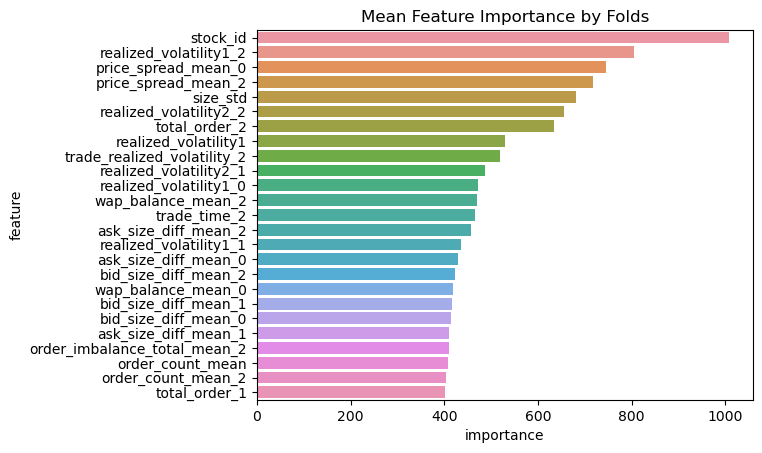

In [ ]:
mean_importance = feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False)


sns.barplot(x=mean_importance[:25],
    y=mean_importance.index[:25])
plt.title('Mean Feature Importance by Folds')
plt.show()